In [1]:
# import modules
%matplotlib inline
import cv2
import numpy as np
import sys
import os
sys.path.append(os.path.join('..', os.getcwd()))
from utils.util import backproject, draw, fibonacci_sphere, estimate_normals, transform_coordinates_3d, calculate_2d_projections, get_3d_bbox
from models.model import PPFEncoder, PointEncoder
from models.voting import backvote_kernel, rot_voting_kernel, ppf_kernel
import MinkowskiEngine as ME
import omegaconf
import torch
import torch.nn as nn
from sklearn.neighbors import KDTree
import cupy as cp
from scipy.ndimage import gaussian_filter
import plotly.graph_objects as go
import plotly.io as pio
from matplotlib import pyplot as plt
import matplotlib
pio.renderers.default = "iframe"

/home/neil/anaconda3/envs/cppf/lib/python3.8/site-packages/MinkowskiEngine/__init__.py:36: UserWarning: The environment variable `OMP_NUM_THREADS` not set. MinkowskiEngine will automatically set `OMP_NUM_THREADS=16`. If you want to set `OMP_NUM_THREADS` manually, please export it on the command line before running a python script. e.g. `export OMP_NUM_THREADS=12; python your_program.py`. It is recommended to set it below 24.
  warnings.warn(


In [2]:
# load parameters and models
angle_tol = 2
num_samples = int(4 * np.pi / (angle_tol / 180 * np.pi))
sphere_pts = np.array(fibonacci_sphere(num_samples))
cp_device = 0

# bowl
path = '../checkpoints/bowl_reg'  # regression bowl
nepoch = 'best'

cfg = omegaconf.OmegaConf.load(f'{path}/.hydra/config.yaml')

point_encoder = PointEncoder(k=cfg['knn'], spfcs=[32, 64, 32, 32], out_dim=32, num_layers=1).cuda().eval()
ppf_encoder = PPFEncoder(ppffcs=[84, 32, 32, 16], out_dim=2 + 2 + 2 + 3).cuda().eval()

# bowl
point_encoder.load_state_dict(torch.load(f'{path}/point_encoder_epoch{nepoch}.pth'))
ppf_encoder.load_state_dict(torch.load(f'{path}/ppf_encoder_epoch{nepoch}.pth'))

intrinsics = np.array([[591.0125, 0, 322.525], [0, 590.16775, 244.11084], [0, 0, 1]])

res = cfg['res']
knn = cfg['knn']
object_scale = 0.3
n_threads = 512
num_rots = 72
bcelogits = nn.BCEWithLogitsLoss()

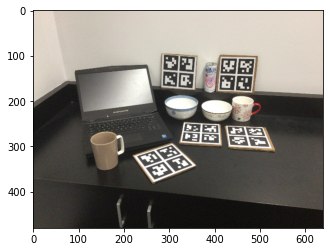

In [3]:
# sample image and depth loading
rgb = cv2.imread('../data/demo/0000_color.png')[..., ::-1]
rgb = (rgb / 255.).astype(np.float32)
depth = cv2.imread('../data/demo/0000_depth.png', -1)
plt.imshow(rgb)
plt.show()

In [4]:
# load sparse and dense point clouds
pc, idxs = backproject(depth, intrinsics, np.ones_like(depth, dtype=bool))
pc /= 1000

# augment
pc = pc + np.clip(res / 4 * np.random.randn(*pc.shape), -res / 2, res / 2)
pc[:, 0] = -pc[:, 0]
pc[:, 1] = -pc[:, 1]

indices = ME.utils.sparse_quantize(np.ascontiguousarray(pc), return_index=True, quantization_size=res)[1]
high_res_pc = pc[indices].astype(np.float32)
high_res_pc_normal = estimate_normals(high_res_pc, knn).astype(np.float32)
hd_kdt = KDTree(high_res_pc)
sparse_res = res * 4
indices = ME.utils.sparse_quantize(high_res_pc, return_index=True, quantization_size=sparse_res)[1]          

pc = high_res_pc[indices]
pc_normal = high_res_pc_normal[indices]

In [5]:
# show point cloud
fig = go.Figure(data=[go.Scatter3d(
        x=pc[:, 0], y=pc[:, 1], z=pc[:, 2],
        mode='markers',
        marker=dict(
            size=2.,
            color='gray',
        )
    ),])
fig.show()

In [6]:
# generate neighbors and point pairs
nbrs_idx = hd_kdt.query(high_res_pc, knn, return_distance=False)

tree = KDTree(pc)
nn_idxs = tree.query_radius(pc, object_scale)
point_idxs = []
for j, nn_idx in enumerate(nn_idxs):
    idxs = np.stack([np.full_like(nn_idx, j), nn_idx], -1)
    point_idxs.append(idxs)

point_idxs = np.random.randint(0, pc.shape[0], (5000000, 2))

In [7]:
# filter out indistinguishable pairs
n1 = pc_normal[point_idxs[:, 0]]
n2 = pc_normal[point_idxs[:, 1]]
ab = pc[point_idxs[:, 0]] - pc[point_idxs[:, 1]]
ab /= (np.linalg.norm(ab, axis=-1, keepdims=True) + 1e-7)
ppf = np.stack([np.sum(n1 * n2, -1), np.sum(ab * n1, -1), np.sum(ab * n2, -1)], -1)
mask = (np.abs(ppf[:, 0]) > 0.9) & (np.abs(ppf[:, 1]) < 0.1) & (np.abs(ppf[:, 2]) < 0.1)
point_idxs = point_idxs[~mask]

In [8]:
# forward model to get voting target
with torch.no_grad():
    sprin_feat = point_encoder.forward_nbrs(torch.from_numpy(high_res_pc[None]).cuda(), torch.from_numpy(high_res_pc_normal[None]).cuda(), torch.from_numpy(nbrs_idx).cuda()[None])[0]
    sprin_feat = sprin_feat[indices]

    preds = ppf_encoder.forward_with_idx(torch.from_numpy(pc).cuda(), torch.from_numpy(pc_normal).cuda(), sprin_feat.cuda(), torch.LongTensor(point_idxs).cuda())
    preds = preds[None]

preds_tr = preds[..., :2]

In [9]:
# get voting heatmap
corners = np.stack([np.min(pc, 0), np.max(pc, 0)])
with cp.cuda.Device(cp_device):
    block_size = (pc.shape[0] ** 2 + 512 - 1) // 512
    
    grid_res = ((corners[1] - corners[0]) / cfg.res).astype(np.int32) + 1
    grid_obj = cp.asarray(np.zeros(grid_res, dtype=np.float32))
    ppf_kernel(
        (block_size, 1, 1),
        (512, 1, 1),
        (
            cp.asarray(pc).astype(cp.float32), cp.asarray(preds_tr[0].cpu().numpy()).astype(cp.float32), cp.asarray(np.ones((pc.shape[0],))).astype(cp.float32), 
            cp.asarray(point_idxs).astype(cp.int32), grid_obj, cp.asarray(corners[0]), cp.float32(cfg.res), 
            point_idxs.shape[0], num_rots, grid_obj.shape[0], grid_obj.shape[1], grid_obj.shape[2], True
        )
    )

    grid_obj = grid_obj.get()

In [10]:
# generate proposals
smoothed_grid = gaussian_filter(grid_obj, sigma=1)

thresh = 50
margin = 10
proposals = []
max_val = None
while True:
    loc = np.array(np.unravel_index([np.argmax(smoothed_grid, axis=None)], smoothed_grid.shape)).T[::-1][0]
    lll = np.maximum(np.array([0, 0, 0]), loc - margin)
    rrr = np.minimum(np.array(smoothed_grid.shape) - 1, loc + margin)
    nbr_val = (np.mean(smoothed_grid[lll[0]:rrr[0], lll[1], lll[2]])
            + np.mean(smoothed_grid[lll[0]:rrr[0], lll[1], rrr[2]])
            + np.mean(smoothed_grid[lll[0]:rrr[0], rrr[1], lll[2]])
            + np.mean(smoothed_grid[lll[0]:rrr[0], rrr[1], rrr[2]])
            + np.mean(smoothed_grid[lll[0], lll[1]:rrr[1], lll[2]])
            + np.mean(smoothed_grid[lll[0], lll[1]:rrr[1], rrr[2]])
            + np.mean(smoothed_grid[rrr[0], lll[1]:rrr[1], lll[2]])
            + np.mean(smoothed_grid[rrr[0], lll[1]:rrr[1], rrr[2]])
            + np.mean(smoothed_grid[lll[0], lll[1], lll[2]:rrr[2]])
            + np.mean(smoothed_grid[lll[0], rrr[1], lll[2]:rrr[2]])
            + np.mean(smoothed_grid[rrr[0], lll[1], lll[2]:rrr[2]])
            + np.mean(smoothed_grid[rrr[0], rrr[1], lll[2]:rrr[2]])) / 12
    diff = smoothed_grid[loc[0], loc[1], loc[2]] - nbr_val
    if diff > thresh:
        if max_val is None:
            max_val = diff
        proposals.append((loc, smoothed_grid[loc[0], loc[1], loc[2]], diff))
    if diff < thresh or diff < max_val * 0.7:
        break
    smoothed_grid[lll[0]:rrr[0], lll[1]:rrr[1], lll[2]:rrr[2]] = 0

scene_locs = []
for loc, cnt, diff in proposals:
    world_coord = corners[0] + loc * res
    scene_locs.append((world_coord, cnt, diff))

In [11]:
print(len(scene_locs))

2


In [12]:
colors = np.full_like(pc, 125, int)
cmap = matplotlib.cm.get_cmap('hsv')
draw_image_bbox = rgb.copy()
for i, (T_est, cnt, diff) in enumerate(scene_locs):
    block_size = (point_idxs.shape[0] + n_threads - 1) // n_threads
    pred_center = T_est
    with cp.cuda.Device(cp_device):
        output_ocs = cp.zeros((point_idxs.shape[0], 3), cp.float32)
        backvote_kernel(
            (block_size, 1, 1),
            (n_threads, 1, 1),
            (
                cp.asarray(pc), cp.asarray(preds_tr[0].cpu().numpy()), output_ocs, cp.asarray(point_idxs).astype(cp.int32), cp.asarray(corners[0]), cp.float32(res), 
                point_idxs.shape[0], num_rots, grid_obj.shape[0], grid_obj.shape[1], grid_obj.shape[2], cp.asarray(pred_center).astype(cp.float32), cp.float32(3 * res)
            )
        )
    oc = output_ocs.get()
    mask = np.any(oc != 0, -1)
    point_idxs_masked = point_idxs[mask]

    # unsupervised instance segmentation
    pc_idxs = np.array(list(set(list(point_idxs_masked.reshape(-1)))), int)
    contrib_cnt = (point_idxs_masked.reshape(-1, 1) == pc_idxs[None]).sum(0)
    pc_idxs = pc_idxs[contrib_cnt > 12]
    point_idxs_masked = point_idxs_masked[np.any(point_idxs_masked[:, 0:1] == pc_idxs[None], 1) | np.any(point_idxs_masked[:, 1:2] == pc_idxs[None], 1)]
    mask = np.zeros((pc.shape[0],), bool)
    mask[pc_idxs] = True


    colors[mask] = (np.array(cmap(i / len(scene_locs))[:3]) * 255.).astype(int)
    
    with torch.no_grad():
        preds_masked = ppf_encoder.forward_with_idx(torch.from_numpy(pc).cuda(), torch.from_numpy(pc_normal).cuda(), sprin_feat.cuda(), torch.LongTensor(point_idxs_masked).cuda())[None]

        preds_tr_masked = preds_masked[..., :2]
        preds_up_masked = preds_masked[..., 2]
        preds_up_aux_masked = preds_masked[..., 4]

        preds_scale_masked = preds_masked[..., -3:]
        
        # fine-grained center voting
        corners = np.stack([np.min(pc, 0), np.max(pc, 0)])
        with cp.cuda.Device(cp_device):
            block_size = (pc.shape[0] ** 2 + 512 - 1) // 512

            grid_res = ((corners[1] - corners[0]) / cfg.res).astype(np.int32) + 1
            grid_obj = cp.asarray(np.zeros(grid_res, dtype=np.float32))
            ppf_kernel(
                (block_size, 1, 1),
                (512, 1, 1),
                (
                    cp.asarray(pc).astype(cp.float32), cp.asarray(preds_tr_masked[0].cpu().numpy()).astype(cp.float32), cp.asarray(np.ones((pc.shape[0],))).astype(cp.float32), 
                    cp.asarray(point_idxs_masked).astype(cp.int32), grid_obj, cp.asarray(corners[0]), cp.float32(cfg.res), 
                    point_idxs_masked.shape[0], num_rots, grid_obj.shape[0], grid_obj.shape[1], grid_obj.shape[2], True
                )
            )

            grid_obj = grid_obj.get()
            
        # fine-grained rotation voting
        with cp.cuda.Device(cp_device):
            up_candidates = cp.zeros((point_idxs_masked.shape[0], num_rots, 3), cp.float32)

            block_size = (point_idxs_masked.shape[0] + n_threads - 1) // n_threads
            rot_voting_kernel(
                (block_size, 1, 1),
                (n_threads, 1, 1),
                (
                    cp.asarray(pc), cp.asarray(preds_tr_masked[0].cpu().numpy()), cp.asarray(preds_up_masked[0].cpu().numpy()), up_candidates, cp.asarray(point_idxs_masked).astype(cp.int32), cp.asarray(corners[0]), cp.float32(res), 
                    point_idxs_masked.shape[0], num_rots, grid_obj.shape[0], grid_obj.shape[1], grid_obj.shape[2]
                )
            )
        up_candidates = up_candidates.get().reshape(-1, 3)
        start = np.arange(0, point_idxs_masked.shape[0] * num_rots, num_rots)
        np.random.shuffle(start)
        sub_sample_idx = (start[:10000, None] + np.arange(num_rots)[None]).reshape(-1)
        up_candidates = up_candidates[sub_sample_idx]

        cos = np.matmul(up_candidates, sphere_pts.T)
        counts = np.sum(cos > np.cos(angle_tol / 180 * np.pi), 0)
        best_up = np.array(sphere_pts[np.argmax(counts)])

        # aux classification
        ab = pc[point_idxs_masked[:, 0]] - pc[point_idxs_masked[:, 1]]
        distsq = np.sum(ab ** 2, -1)
        ab_normed = ab / (np.sqrt(distsq) + 1e-7)[..., None]
        pairwise_normals = pc_normal[point_idxs_masked[:, 0]]
        pairwise_normals[np.sum(pairwise_normals * ab_normed, -1) < 0] *= -1
        preds_up_aux_masked = preds_up_aux_masked[0]
        with torch.no_grad():
            target = torch.from_numpy((np.sum(pairwise_normals * best_up, -1) > 0).astype(np.float32)).cuda()
            up_loss = bcelogits(preds_up_aux_masked, target).item()
            down_loss = bcelogits(preds_up_aux_masked, 1. - target).item()

        if down_loss < up_loss:
            up = -best_up
        else:
            up = best_up

        # fine-grained estimation
        right = np.array([0, -up[2], up[1]])
        right /= np.linalg.norm(right)
        R_est_fi = np.stack([right, up, np.cross(right, up)], -1)

        pred_scale_3d = np.mean(np.exp(preds_scale_masked[0].cpu().numpy()) * cfg.scale_mean * 2, 0)
        scale = np.linalg.norm(pred_scale_3d)

        RT = np.eye(4)
        RT[:3, :3] = R_est_fi * scale
        RT[:3, -1] = T_est
        
        # draw bbox visualization
        xyz_axis = 0.3 * np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0], [1, 0, 0]]).transpose()
        transformed_axes = transform_coordinates_3d(xyz_axis, RT)
        projected_axes = calculate_2d_projections(transformed_axes, intrinsics)

        bbox_3d = get_3d_bbox(pred_scale_3d / scale, 0)
        transformed_bbox_3d = transform_coordinates_3d(bbox_3d, RT)
        projected_bbox = calculate_2d_projections(transformed_bbox_3d, intrinsics)
        draw_image_bbox = draw(draw_image_bbox, projected_bbox, projected_axes, (1., 0, 0))

In [13]:
# visualize instsance segmentation
fig = go.Figure(data=[go.Scatter3d(
        x=pc[:, 0], y=pc[:, 1], z=pc[:, 2],
        mode='markers',
        marker=dict(
            size=2.,
            color=colors,
        )
    ),])
fig.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


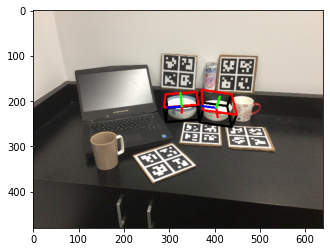

In [14]:
# visualize 9D bbox prediction
plt.imshow(draw_image_bbox)
plt.show()